이번에 우리는 Movielens 1M Dataset을 기반으로, Session based Recommendation 시스템을 제작해 보겠습니다.

우선 주요 라이브러리 버전을 확인해 보죠.


In [1]:
import datetime as dt
from pathlib import Path
import os

import numpy as np
import pandas as pd
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

In [2]:
data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose/data/') 
train_path = data_path / 'ratings.dat'
train_path

PosixPath('/aiffel/aiffel/yoochoose/data/ratings.dat')

In [3]:
def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, 
                       usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
                                    # header : read_csv() 함수는 기본적으로 첫번째 행을 header(열이름)로 지정해서 불러온다. 
                                    # 하지만 불러올 데이터에 header가 없을 경우 header=None 옵션을 주어야 함
                                    # usecols : 실제로 dataframe에 로딩할 columns만 설정.
                                    # parse_dates : https://mskim8717.tistory.com/176
    data.columns = ['UserId', 'ItemId', 'Rating', 'Timestamp']
    return data

data = load_data(train_path, None)
data.sort_values(['UserId', 'Timestamp'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
                                                     # sort_values : ['UserId', 'Time']으로 되어 있으면 먼저 UserId 기준으로 정렬한 이후 각 세션안에서 Time 기준으로 다시 정렬한다
data

,UserId,ItemId,Rating,Timestamp
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


In [4]:
# timestamp를 datetime으로 변환
data['Time'] = pd.to_datetime(data['Timestamp'], unit='s')  # Timestamp가 초단위 이므로 unit='s'로 해줌
                                                            # https://pandas.pydata.org/docs/reference/api/pandas.to_datetime.html
data

,UserId,ItemId,Rating,Timestamp,Time
31,1,3186,4,978300019,2000-12-31 22:00:19
22,1,1270,5,978300055,2000-12-31 22:00:55
27,1,1721,4,978300055,2000-12-31 22:00:55
37,1,1022,5,978300055,2000-12-31 22:00:55
24,1,2340,3,978300103,2000-12-31 22:01:43
...,...,...,...,...,...
1000019,6040,2917,4,997454429,2001-08-10 14:40:29
999988,6040,1921,4,997454464,2001-08-10 14:41:04
1000172,6040,1784,3,997454464,2001-08-10 14:41:04
1000167,6040,161,3,997454486,2001-08-10 14:41:26


In [5]:
data[data['UserId'] == 75]

,UserId,ItemId,Rating,Timestamp,Time
10581,75,634,3,977850585,2000-12-26 17:09:45
10460,75,3054,3,977850614,2000-12-26 17:10:14
10500,75,2628,5,977850661,2000-12-26 17:11:01
10565,75,1210,4,977850704,2000-12-26 17:11:44
10428,75,1196,4,977850778,2000-12-26 17:12:58
...,...,...,...,...,...
10541,75,2694,4,978750251,2001-01-06 03:04:11
10512,75,1911,5,978750303,2001-01-06 03:05:03
10495,75,3408,5,978750335,2001-01-06 03:05:35
10497,75,2392,5,978750501,2001-01-06 03:08:21


In [6]:
# SessionId 생성 함수 정의하기
# 각 행의 시간 차이가 짧으면 같은 SessionId로 간주하고 연속된 행의 시간차이가 10분 이상 차이가 된다면 서로 다른 SessionId로 가정한다
# 그 이유는 브라우저 들어간 사람이 브라우저 종료했다가 일정 시간(여기서는 10분) 이후에 다시 접속해서 시청한 것으로 가정함
# data['SessionID'] = data.groupby('UserId')['Timestamp'].diff(periods=60)
def make_sessionid(data):
    data['userid_diff'] = data.diff()['UserId']
    data['time_diff'] = data.diff()['Timestamp']
    session = [1]
    s = 1
    for id_diff, t_diff in zip(data['userid_diff'][1:], data['time_diff'][1:]):
        if (id_diff == 0) & (t_diff < 600):
            session.append(s)
        else:
            s += 1
            session.append(s)
            continue
    data['SessionId'] = session  # 만들어진 SessionId 리스트를 삽입
    
    return data

In [7]:
data = make_sessionid(data)
data

,UserId,ItemId,Rating,Timestamp,Time,userid_diff,time_diff,SessionId
31,1,3186,4,978300019,2000-12-31 22:00:19,NaN,NaN,1
22,1,1270,5,978300055,2000-12-31 22:00:55,0.0,36.0,1
27,1,1721,4,978300055,2000-12-31 22:00:55,0.0,0.0,1
37,1,1022,5,978300055,2000-12-31 22:00:55,0.0,0.0,1
24,1,2340,3,978300103,2000-12-31 22:01:43,0.0,48.0,1
...,...,...,...,...,...,...,...,...
1000019,6040,2917,4,997454429,2001-08-10 14:40:29,0.0,31.0,28384
999988,6040,1921,4,997454464,2001-08-10 14:41:04,0.0,35.0,28384
1000172,6040,1784,3,997454464,2001-08-10 14:41:04,0.0,0.0,28384
1000167,6040,161,3,997454486,2001-08-10 14:41:26,0.0,22.0,28384


- 여기서 이전 실습 내역과 가장 크게 다른 부분은 바로 SessionID 대신 UserID 항목이 들어갔다는 점입니다. 이 데이터셋은 명확한 1회 세션의 SessionID를 포함하지 않고 있습니다. 그래서 이번에는 UserID가 SessionID 역할을 해야 합니다.
- Rating 정보가 포함되어 있습니다. 이전 실습 내역에서는 이런 항목이 포함되어 있지 않았으므로, 무시하고 제외할 수 있습니다. 하지만, 직전에 봤던 영화가 맘에 들었는지가 비슷한 영화를 더 고르게 하는 것과 상관이 있을 수도 있습니다. 아울러, Rating이 낮은 데이터를 어떻게 처리할지도 고민해야 합니다.
- Time 항목에는 UTC time 가 포함되어, 1970년 1월 1일부터 경과된 초 단위 시간이 기재되어 있습니다.  
위와 같은 정보를 바탕으로 오늘의 실습과정과 유사한 프로젝트 과정을 진행해 보겠습니다.

# Step 1. 데이터의 전처리

위와 같이 간단히 구성해 본 데이터셋을 꼼꼼히 살펴보면서 항목별 기본 분석, session length, session time, cleaning 등의 작업을 진행합니다.  
특히, 이 데이터셋에서는 Session이 아닌 UserID 단위로 데이터가 생성되어 있으므로, 이를 Session 단위로 어떻게 해석할지에 주의합니다.

## 1.1 Session Length
여기서 session_length란 같은 SessionId를 공유하는 데이터 row의 개수를 의미합니다. 여기서 SessionId란 브라우저에서 웹서버로 접속할 때 항상 포함하게 되는 유저 구분자입니다. 로그인하지 않았기 때문에 이 사용자가 누군지는 알 수 없어도, 최소한 특정 사용자의 행동을 SessionId 기준으로 모아서 분류해낼 수는 있습니다. 따라서 여기서 session_length란 해당 세션의 사용자가 그 세션 동안 몇 번의 액션을 취했는지(몇 개의 상품정보를 클릭했는지)의 의미가 됩니다.

In [8]:
session_length = data.groupby('SessionId').size()
session_length

SessionId
1         12
2         28
3         13
4        129
5         51
        ... 
28381      7
28382     14
28383      1
28384     21
28385      1
Length: 28385, dtype: int64

In [9]:
session_length.median(), session_length.mean()

(6.0, 35.23723797780518)

In [10]:
session_length.min(), session_length.max()

(1, 1193)

In [11]:
session_length.quantile(0.999)

683.080000000009

각 세션의 길이는 보통 6~35 정도입니다. 온라인에서 쇼핑할 때를 생각해 보면 이 수치가 그럴듯하게 느껴집니다. 99.9% 세션은 길이가 683이하입니다. 길이가 1193인 세션은 뭔가 이상합니다. 하나를 잡고 살펴봅시다.

In [12]:
long_session = session_length[session_length==1193].index[0]
data[data['SessionId']==long_session]

,UserId,ItemId,Rating,Timestamp,Time,userid_diff,time_diff,SessionId
637775,3841,1480,3,965995059,2000-08-11 11:57:39,0.0,79091.0,18620
637808,3841,969,5,965995059,2000-08-11 11:57:39,0.0,0.0,18620
638269,3841,858,5,965995059,2000-08-11 11:57:39,0.0,0.0,18620
638716,3841,2019,5,965995059,2000-08-11 11:57:39,0.0,0.0,18620
638733,3841,1221,5,965995059,2000-08-11 11:57:39,0.0,0.0,18620
...,...,...,...,...,...,...,...,...
638038,3841,3806,5,966003791,2000-08-11 14:23:11,0.0,0.0,18620
638243,3841,1379,2,966003791,2000-08-11 14:23:11,0.0,0.0,18620
638459,3841,1928,4,966003791,2000-08-11 14:23:11,0.0,0.0,18620
638710,3841,2016,3,966003791,2000-08-11 14:23:11,0.0,0.0,18620


매우 짧은 간격으로 지속적으로 클릭을 1시간 30분가량 지속하고 있습니다. 유저들의 서비스 이용행태는 다양하기 때문에 데이터 전처리를 어떻게 할지는 모델을 만드는 사람이 판단해야 합니다. e.g.) 음악 데이터의 경우 어떤 사람은 하루 종일 랜덤 재생을 할 수도 있습니다. 이 유저의 데이터를 그대로 사용하는 게 좋을까요? e.g.) 어떤 상품의 경우 1분 내에 20명이 10점을 주고 나갈 수도 있습니다. 이 상품을 팔기 위해 조작하고 있는 건 아닐까요?
너무 긴 세션을 제거할 수도 있고 포함시킬 수도 있습니다. 어떻게 하면 좋을지 판단해 보세요.
세션 길이에 대한 감을 더 잘 파악하기 위해 시각화를 해보겠습니다. 

아래는 세션 길이 기준 하위 99.9%까지의 분포 누적합을 시각화한 것입니다.

In [13]:
length_count = session_length.groupby(session_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()     # cumsum() : Return cumulative sum over a DataFrame or Series axis.
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

length_percent_cumsum_999

1      0.280148
2      0.383054
3      0.433750
4      0.467818
5      0.498538
         ...   
663    0.998802
670    0.998873
671    0.998908
674    0.998943
680    0.998978
Length: 508, dtype: float64

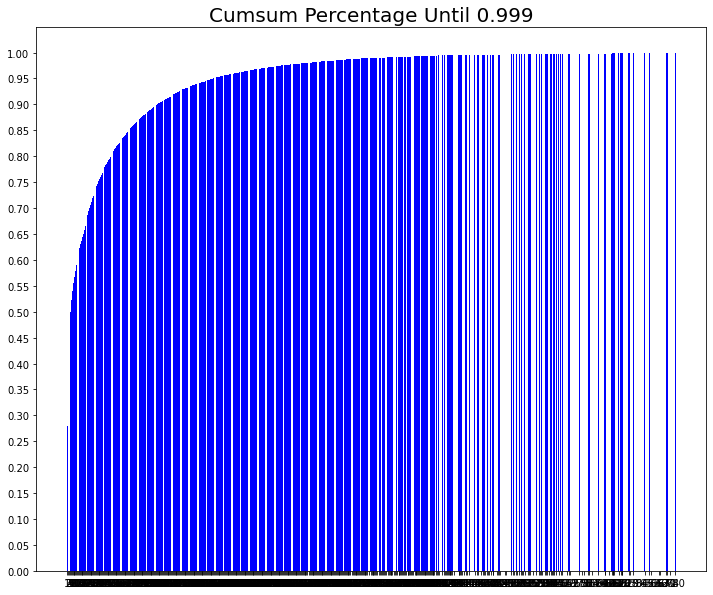

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
plt.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999, color='blue')
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

> 누적이므로 급격하게 상승한 부분이 많이 몰려있음을 나타냄

## 1.2 Session Time
- 어떤 유저가 아이폰을 구매하려고 합니다. 2020년 5월에는 아이폰 SE2를 구매하려는 사람이 많을 것입니다.
- 그러나 그로부터 몇 달 후면 아이폰 12의 구매량이 엄청나게 증가하게 될 것입니다.
- 영화나 드라마 역시 마찬가지입니다. 유저들의 소비 패턴을 금방금방 변합니다.
- 이런 이유 때문에 추천 시스템을 구축할 때에는 __최근 소비 트렌드를 학습__하는 것이 중요합니다. 이번에는 데이터가 발생한 시간에 대해 알아봅시다.

In [15]:
oldest, latest = data['Time'].min(), data['Time'].max()
print(oldest) 
print(latest)

2000-04-25 23:05:32
2003-02-28 17:49:50


In [16]:

# month_ago = latest - dt.timedelta(30)     # 최종 날짜로부터 30일 이전 날짜를 구한다.  
# data = data[data['Time'] > month_ago]     # 방금 구한 날짜 이후의 데이터만 모은다. 
# data

## 1.3 Cleaning
1.2에서 살펴보니 길이가 1인 세션도 꽤 있습니다. 우리의 목적은 유저가 최소 1개 이상 클릭했을 때 다음 클릭을 예측하는 것이므로 길이가 1인 세션은 제거해 줍니다.  

너무 적게 클릭된 아이템은 이상한 아이템일 가능성이 있습니다. 이 역시 제거해 줍니다.

In [17]:
# rating 점수 3점 이상이 되어야 해당 유저의 선호도가 있음을 가정
# 즉, 관련(relevant) 항목은 평점 3점 이상의 영화, 그 미만은 무관련(irrelevant) 항목으로 가정
data = data[data['Rating'] >= 3]
data

,UserId,ItemId,Rating,Timestamp,Time,userid_diff,time_diff,SessionId
31,1,3186,4,978300019,2000-12-31 22:00:19,NaN,NaN,1
22,1,1270,5,978300055,2000-12-31 22:00:55,0.0,36.0,1
27,1,1721,4,978300055,2000-12-31 22:00:55,0.0,0.0,1
37,1,1022,5,978300055,2000-12-31 22:00:55,0.0,0.0,1
24,1,2340,3,978300103,2000-12-31 22:01:43,0.0,48.0,1
...,...,...,...,...,...,...,...,...
1000019,6040,2917,4,997454429,2001-08-10 14:40:29,0.0,31.0,28384
999988,6040,1921,4,997454464,2001-08-10 14:41:04,0.0,35.0,28384
1000172,6040,1784,3,997454464,2001-08-10 14:41:04,0.0,0.0,28384
1000167,6040,161,3,997454486,2001-08-10 14:41:26,0.0,22.0,28384


In [18]:
# short_session을 제거한 다음 unpopular item을 제거하면 다시 길이가 1인 session이 생길 수 있습니다
# 왜냐하면 item행을 하나 지웠을 때 item을 지우기 전에는 최소세션 길이를 넘어 session을 안지웠는데 item행을 지우고 나니 최소행이 되는 경우가 있으므로
# 이를 위해 반복문을 통해 지속적으로 제거 합니다.
def cleanse_recursive(data: pd.DataFrame, shortest, least_click) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_short_session(data, shortest)
        data = cleanse_unpopular_item(data, least_click)
        after_len = len(data)
        if before_len == after_len:
            break
    return data


# shortest보다 높은 세션들만 뽑음
def cleanse_short_session(data: pd.DataFrame, shortest):
    session_len = data.groupby('SessionId').size()
    session_use = session_len[session_len >= shortest].index
    data = data[data['SessionId'].isin(session_use)]
    return data


# least_click보다 높은 아이템들만 뽑음
def cleanse_unpopular_item(data: pd.DataFrame, least_click):
    item_popular = data.groupby('ItemId').size()
    item_use = item_popular[item_popular >= least_click].index
    data = data[data['ItemId'].isin(item_use)]
    return data

In [19]:
data = cleanse_recursive(data, shortest=2, least_click=5)
data

,UserId,ItemId,Rating,Timestamp,Time,userid_diff,time_diff,SessionId
31,1,3186,4,978300019,2000-12-31 22:00:19,NaN,NaN,1
22,1,1270,5,978300055,2000-12-31 22:00:55,0.0,36.0,1
27,1,1721,4,978300055,2000-12-31 22:00:55,0.0,0.0,1
37,1,1022,5,978300055,2000-12-31 22:00:55,0.0,0.0,1
24,1,2340,3,978300103,2000-12-31 22:01:43,0.0,48.0,1
...,...,...,...,...,...,...,...,...
999923,6040,232,5,997454398,2001-08-10 14:39:58,0.0,31.0,28384
1000019,6040,2917,4,997454429,2001-08-10 14:40:29,0.0,31.0,28384
999988,6040,1921,4,997454464,2001-08-10 14:41:04,0.0,35.0,28384
1000172,6040,1784,3,997454464,2001-08-10 14:41:04,0.0,0.0,28384


In [20]:
# 학습에 필요한 컬럼만 추출
data = data[['SessionId', 'ItemId', 'Rating', 'Time']]
data

,SessionId,ItemId,Rating,Time
31,1,3186,4,2000-12-31 22:00:19
22,1,1270,5,2000-12-31 22:00:55
27,1,1721,4,2000-12-31 22:00:55
37,1,1022,5,2000-12-31 22:00:55
24,1,2340,3,2000-12-31 22:01:43
...,...,...,...,...
999923,28384,232,5,2001-08-10 14:39:58
1000019,28384,2917,4,2001-08-10 14:40:29
999988,28384,1921,4,2001-08-10 14:41:04
1000172,28384,1784,3,2001-08-10 14:41:04


## 1.4 Train / Valid / Test split
Test 셋을 살펴보니 Training 셋과 기간이 겹칩니다.  
하지만 1.3에서 말했듯이 추천 시스템은 지금 잘 예측하는 게 중요합니다.  
1달 전에 성능이 좋은 모델을 지금 쓰면 맞지 않을 수가 있는데, 사용자들의 소비 패턴이 달라지기 때문입니다.  
이런 이유로 Session-Based Recommendation에서는 기간에 따라 Train/ Valid/ Test 셋을 나누기도 합니다.

이번 자료에서는 가장 마지막 1일 기간 동안을 Test로, 2일 전부터 1일 전 까지를 valid set으로 나누겠습니다.
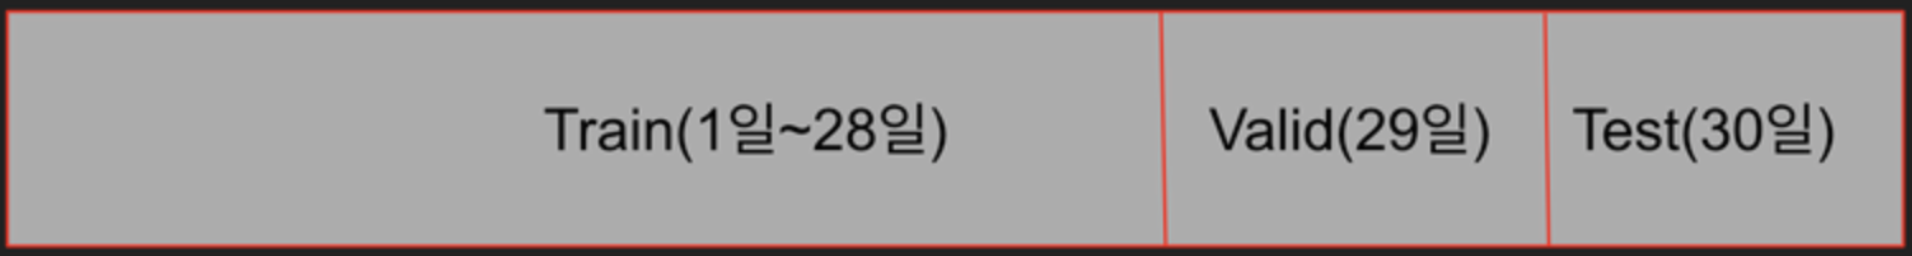

In [21]:
def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['Time'].max()
    session_last_time = data.groupby('SessionId')['Time'].max()
    session_in_train = session_last_time[session_last_time < final_time - dt.timedelta(n_days)].index
    session_in_test = session_last_time[session_last_time >= final_time - dt.timedelta(n_days)].index

    before_date = data[data['SessionId'].isin(session_in_train)]
    after_date = data[data['SessionId'].isin(session_in_test)]
    after_date = after_date[after_date['ItemId'].isin(before_date['ItemId'])] # extract the items which exist in the both train and test data
    return before_date, after_date

In [22]:
tr, test = split_by_date(data, n_days=50)
tr, val = split_by_date(tr, n_days=100)

In [23]:
# train, val, test data에 대한 정보를 살펴봅니다.
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Number of Events: {len(data)}\n'
          f'\t Number of Unique Sessions: {data["SessionId"].nunique()}\n'
          f'\t Number of Unique Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')

In [24]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Number of Events: 822507
	 Number of Unique Sessions: 18878
	 Number of Unique Items: 3298
	 First Time : 2000-04-25 23:05:32
	 Last Time : 2002-09-30 23:52:29

* valid Set Stats Info
	 Number of Events: 3767
	 Number of Unique Sessions: 344
	 Number of Unique Items: 1522
	 First Time : 2002-10-01 09:33:35
	 Last Time : 2003-01-09 05:14:04

* test Set Stats Info
	 Number of Events: 1823
	 Number of Unique Sessions: 162
	 Number of Unique Items: 1067
	 First Time : 2003-01-10 13:54:07
	 Last Time : 2003-02-28 17:49:50



In [25]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

In [26]:
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

# Dataframe.to_pickle : Pickle (serialize) object to file.
tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

# Step 2. 미니 배치의 구성

실습 코드 내역을 참고하여 데이터셋과 미니 배치를 구성해 봅시다. Session-Parallel Mini-Batch의 개념에 따라, 학습 속도의 저하가 최소화될 수 있도록 구성합니다.
단, 위 Step 1에서 Session 단위를 어떻게 정의했느냐에 따라서 Session-Parallel Mini-Batch이 굳이 필요하지 않을 수도 있습니다.

## 2.1 SessionDataset
데이터가 주어지면 
- __세션이 시작되는 인덱스__를 담는 값과
- 세션을 새로 __인덱싱__한 값을 갖는 클래스

를 만듭니다.

In [27]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()                 # 각 session이 "시작"되는 인덱스를 담는 변수
        self.session_idx = np.arange(self.df['SessionId'].nunique())  # indexing of total SessionId 

    def get_click_offsets(self):
        """
        Return the indices of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['SessionId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('SessionId').size().cumsum()    # 오른쪽 한 칸 offset시킴. 0번지에는 숫자 0
        return offsets

train데이터로 SessionDataset 객체를 만들고 인스턴스 변수들을 살펴보겠습니다.

click_offsets 변수는 __각 세션이 시작된 인덱스를 담고 있습__니다.

session_idx 변수는 각 세션을 인덱싱한 np.array 입니다.

In [28]:
tr_dataset = SessionDataset(tr)
tr_dataset.df.head(10)

,SessionId,ItemId,Rating,Time,item_idx
31,1,3186,4,2000-12-31 22:00:19,0
22,1,1270,5,2000-12-31 22:00:55,1
27,1,1721,4,2000-12-31 22:00:55,2
37,1,1022,5,2000-12-31 22:00:55,3
24,1,2340,3,2000-12-31 22:01:43,4
36,1,1836,5,2000-12-31 22:02:52,5
3,1,3408,4,2000-12-31 22:04:35,6
7,1,2804,5,2000-12-31 22:11:59,7
47,1,1207,4,2000-12-31 22:11:59,8
0,1,1193,5,2000-12-31 22:12:40,9


In [29]:
tr_dataset.click_offsets

array([     0,     12,     40, ..., 822473, 822486, 822507], dtype=int32)

In [30]:
tr_dataset.session_idx

array([    0,     1,     2, ..., 18875, 18876, 18877])

## 4.2 SessionDataLoader
파이썬 문법 중 iterator, generator에 대한 좀 더 친절한 안내가 필요하신 분은 이 [자료](https://dojang.io/mod/page/view.php?id=2405)를 먼저 보시길 권장합니다.

SessionDataset __객체를 받아서 Session-Parallel mini-batch를 만드는 클래스를 만듭__니다.

__iter__ 메서드는 모델 인풋, 라벨, 세션이 끝나는 곳의 위치를 yield합니다.

mask는 후에 RNN Cell State를 초기화하는데 사용할 것입니다.

In [31]:
# 클래스 인스턴스(객체)를 받아서 Session-Parallel mini-batch를 만드는 클래스를 만듦
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1       # Shortest Length Among Sessions  ???? 왜 -1을 뺄까?
            for i in range(min_len):
                # Build inputs & targets
                input_ = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield input_, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # @ 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1          # @ 배치에서 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]    # @ data 상에서 각 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # @ 각 session이 끝난 위치 바로 다음 위치를 가져옵니다.
                                                                                     # 또한 end는 다음 세션의 시작 위치이다
        mask = np.array([])      # @ session의 모든 아이템을 다 돌은 경우 mask에 추가해주기 위해 빈 리스트 생성
        finished = False         # @ data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
                           # ??????????????????
        
        # @ start는 이 함수가 실행될 때마다 min_len만큼 더해지는 업데이트가 수행됐음을 생각하고 해석해라
        # @ end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1] 
       
        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # @ 만약 새로운 세션이 전체 세션의 마지막 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
                
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [32]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head(15)

,SessionId,ItemId,Rating,Time,item_idx
31,1,3186,4,2000-12-31 22:00:19,0
22,1,1270,5,2000-12-31 22:00:55,1
27,1,1721,4,2000-12-31 22:00:55,2
37,1,1022,5,2000-12-31 22:00:55,3
24,1,2340,3,2000-12-31 22:01:43,4
36,1,1836,5,2000-12-31 22:02:52,5
3,1,3408,4,2000-12-31 22:04:35,6
7,1,2804,5,2000-12-31 22:11:59,7
47,1,1207,4,2000-12-31 22:11:59,8
0,1,1193,5,2000-12-31 22:12:40,9


In [33]:
iter_ex = iter(tr_data_loader)

아래 셀을 반복 실행하면 next가 계속 다음 데이터를 만듭니다.
input, output, mask의 감을 잡아 봅시다.

In [34]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [ 0 12 40 53]
Label Item Idx are :       [ 1 13 41 54]
Previous Masked Input Idx are []


# Step 3. 모델 구성

이 부분도 실습 코드 내역을 참고하여 다양하게 모델 구조를 시도해 볼 수 있습니다.



## 3.1 Evaluation Metric
모델 성능 평가를 위한 지표를 보겠습니다.  
모델 성능에 대한 지표로 precision이나 recall이 있습니다.  
Session-Based Recommendation Task에서는 __모델이 k개의 아이템을 제시했을 때, 유저가 클릭 또는 구매한 n개의 아이템이 많아야 좋습니다.__  
이 때문에 recall의 개념을 확장한 recall@k 지표, precision의 개념을 확장한 Mean Average Precision@k 지표 등을 사용합니다.  
추천에서는 몇 번째로 맞추느냐도 중요합니다. 구글에서 검색했을 때 1페이지에 원하는 결과가 나오지 않고 2페이지에 나온다면 유저 반응이 크게 떨어질 것입니다.  
따라서 순서에 민감한 지표인 MRR, NDCG 같은 지표도 사용합니다.  
이번 자료에서는 
- [MRR](https://jyoondev.tistory.com/131)과 
- [Recall@k](https://medium.com/@junhoher/추천-시스템-평가-지표-두-가지-recall-k-및-precision-k-6b2032e2e360)를 

사용하겠습니다.

__MRR__은 __추천했을 때, 정답 아이템이 나온 순번의 역수 값__입니다.  
따라서 정답 아이템이 추천 결과 앞쪽 순번에 나온다면 지표가 높아질 것이고 뒤쪽에 나오거나 안 나온다면 지표가 낮아질 것입니다.  

In [35]:
def mrr_k(pred, truth: int, k: int):
    # 예측한 것이 정답지(선호 아이템)에 있으면 해당 인덱스를 담는 변수
    indexing = np.where(pred[:k] == truth)[0]  # np.where(조건): 조건이 맞으면 해당 인덱스를 반환
                                               # np.where -> (array([...]))이므로. [0]인덱싱 추가하였음
                                               # https://jimmy-ai.tistory.com/46
                                               # truth : 정답지, 즉 선호하는 item
                                               # 추천 상위 k개만 뽑을 것이므로 pred[:k]임

    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)  # +1하는 이유는 인덱스에 1을 더해야 해당 아이템의 "순번"이 되므로. 즉, 순번은 1부터시작, not 0
                                      # indexing에서 첫번째 아이템 인덱스가 mrr 계산식에서 계산됨.
                                      # MRR은 순번의 역수를 값으로 함
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:      # ????????????????????
    answer = truth in pred[:k]                      # truth : 정답지, 즉 선호하는 item
    return int(answer)

## 3.2 Model Architecture
스텝 3에서 소개한 모델 구조를 구현하겠습니다. 모델 구조가 간단한 편이므로 Functional하게 모델을 만들겠습니다.

In [36]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical  # one-hot 인코딩해주는 함수
from tqdm import tqdm

In [44]:
# 모델 생성 함수 정의
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [45]:
# 모델에 사용할 hyper-parameter를 클래스 형식으로 생성 및 관리
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['SessionId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(tr, val, test, batch_size=128, hsz=50, drop_rate=0.1, lr=0.001, epochs=10, k=20)

In [46]:
model = create_model(args)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(128, 1, 3298)]          0         
_________________________________________________________________
GRU (GRU)                    [(128, 50), (128, 50)]    502500    
_________________________________________________________________
dropout (Dropout)            (128, 50)                 0         
_________________________________________________________________
dense (Dense)                (128, 3298)               168198    
Total params: 670,698
Trainable params: 670,698
Non-trainable params: 0
_________________________________________________________________


# Step 4. 모델 학습

다양한 하이퍼파라미터를 변경해 보며 검증해 보도록 합니다. 실습 코드에 언급되었던 Recall, MRR 등의 개념들도 함께 관리될 수 있도록 합니다.

In [48]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)  # 각 session이 시작되는 인덱스를 담는 변수를 만들고 sessionId를 정수로 indexing함
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)  # 클래스 인스턴스(객체)를 받아서 Session-Parallel mini-batch를 만드는 클래스를 만듦

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['SessionId'].nunique()      # ??????????????????????????????????
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)  # tqdm : https://skillmemory.tistory.com/entry/tqdm-사용법-python-진행률-프로세스바
                                                                                                        # ???????????
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)  # to_categorical: one-hot 인코딩해주는 함수
                                                                          # num_classes : Total number of classes
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)  # 모델 학습
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")



def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')      # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:                             # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0                # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)

    

def get_metrics(data: test, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['SessionId'].nunique()  # total_step이 뭔가?????????????????????????
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)  # one-hot 인코딩
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)     # 모델 예측!!!
        pred_arg = tf.argsort(pred, direction='DESCENDING')             # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)                                                            # inputs은 세션 길이
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)]) # 정답지 라벨은 선호도를 의미
                                                                                        # extend vs append : https://stackoverflow.com/questions/252703/what-is-the-difference-between-pythons-list-methods-append-and-extend
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [49]:
train_model(model, args)

Train:  51%|█████     | 3184/6278 [01:11<01:09, 44.68it/s, accuracy=0.00781, train_loss=6.63]


KeyboardInterrupt: 

# Step 5. 모델 테스트

미리 구성한 테스트셋을 바탕으로 Recall, MRR 을 확인해 봅니다.

In [ ]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test)

# Step 6. 테스트 결과 
## 테스트 1
- 조건 : batch_size=128, hsz=50, drop_rate=0.1, lr=0.001, epochs=3, k=20, n_days=(100, 100)
- 예측 결과 :
    - Recall@20: 0.153
    - MRR@20: 0.044
    
## 테스트 2
- 조건 : batch_size=128, hsz=50, drop_rate=0.1, lr=0.001, epochs=10, k=20, n_days=(100, 100)
- 예측 결과 :
    - Recall@20: 0.168
    - MRR@20: 0.056
    
## 테스트 3
- 조건 : batch_size=128, hsz=50, drop_rate=0.1, lr=0.01, epochs=10, k=20, n_days=(100, 100)
- 예측 결과 :
    - Recall@20: 0.151
    - MRR@20: 0.0465
    
## 테스트 4
- 조건 : batch_size=128, hsz=50, drop_rate=0.1, lr=0.001, epochs=10, k=20, n_days=(200, 610)
- 예측 결과 :
    - Recall@20: 0.17
    - MRR@20: 0.052
## 테스트 5

## 테스트 4
## 테스트 4


# Step 6. 회고
- 하나의 유저아이디가 여러 가지 세선을 가질 수 있으므로 한 유저에 대해서 최소 10분 공백을 기준으로 세션을 분리하였다. 최소 10분 이상 공백이 생기면 그 유저는 브라우저를 나갔다가 다시 들어와 새로운 세션으로 간주하였다
- 평점을 3이상이면 해당 유저는 그 영화를 선호한다고 가정하였고 전처리 했다
- 데이터 분리시 데이터가 최근 날짜에 가까울수록 데이터 수가 급격히 감소하여서 최근 데이터로 분할하면 검증과 테스트 데이터량이 현저히 적어지기 때문에 분리 날짜를 대략 1년전까지를 테스트데이터로 잡았다.
- 어려웠던 점은 코드이해였다. 지금도 전부 이해하지 못한 부분이 많다. 최대한 코드 하나하나를 찍어보며 파악하려고 했고 파악된 부분은 주석으로 코드 설명을 했다
- Recall 점수가 생각보다 높게 나오지 않고 있다. 여러 하이퍼파라미터를 변경해보았으나 뚜렷이 증가되는 부분이 없었다. 모델 구성을 달리해보는 방법도 찾아봐야겠다